### NLP Classification of Corona Virus Tweets (Kaggle)

The purpose of this notebook is to take a previously Fine-Tuned BERT model for classification tasks, and make predictions on a dataset.

#### Import Packages

In [1]:
# Import Packages
import os
import numpy as np
import pandas as pd
import torch

from datasets import load_dataset
from datasets import load_metric

from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
from transformers import TrainingArguments
from transformers import Trainer

#### Load the data

In [3]:
# Load the dataset you want to make predictions on
dataset = pd.read_csv("C:\\Users\\hlmq\\OneDrive - Chevron\\Data\\DSDP\\CoronaTweets-Kaggle\\Corona_NLP_test.csv"
                   , encoding = "ISO-8859-1")

#### Prepare the Tokenizer and Perform Data Cleanup

In [6]:
# Utility functions

def transform_labels(label):
    num = 5
    
    if label == 'Extremely Positive':
        num = 0
    elif label == 'Positive':
        num = 1
    elif label == 'Neutral':
        num = 2
    elif label == 'Negative':
        num = 3
    elif label == 'Extremely Negative':
        num = 4
    
    return num


# Define utility functions

def transform_labels(label):

    label = label['Sentiment']
    num = 0
    if label == 'Extremely Positive':
        num = 0
    elif label == 'Positive':
        num = 1
    elif label == 'Neutral':
        num = 2
    elif label == 'Negative':
        num = 3
    elif label == 'Extremely Negative':
        num = 4

    return {'labels': num}


In [5]:
# Load tokenizer from transformers library
tokenizer = AutoTokenizer.from_pretrained('bert-base-cased')

# Check to be sure the tokenizer is working
tokenizer("Attention is all you need")

{'input_ids': [101, 1335, 5208, 2116, 1110, 1155, 1128, 1444, 102], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1]}

In [7]:
## Dataset cleanup

# Create new index
dataset_idx = [i for i in range(len(dataset.index))]

# Convert to numpy
X_text = dataset['OriginalTweet'].values[dataset_idx]

X_text = X_text[1:100,]

# Tokenize dataset
X_test = tokenizer(list(X_text), return_tensors='pt', truncation=True, padding=True, max_length=128)

#### Access Pretrained BERT Base

In [8]:
# Import the fine-tuned BERT model from the previous notebook

# This is the number of classes in the dataset
num_classes = 5
# This is the fine tuned BERT model
bert_model = AutoModelForSequenceClassification.from_pretrained('corona_tweet_sentiment.model', num_labels=num_classes)

#### Make Small Sample Predictions

In [9]:
# Random data to test the model
raw_inputs = [
    "I've been waiting for a HuggingFace course my whole life.", 
    "I am very excited about training the model !!",
    "I hate this weather which makes me feel irritated  !"
]

inputs = tokenizer(raw_inputs, padding=True, truncation=True, return_tensors="pt")

# Perform classification task on real data
predictions = bert_model(**inputs)

# Coerce prediction values
predictions = torch.nn.functional.softmax(predictions.logits, dim = -1)

print(predictions)

tensor([[0.1479, 0.1089, 0.7097, 0.0241, 0.0094],
        [0.2096, 0.0275, 0.0246, 0.7275, 0.0108],
        [0.0534, 0.1875, 0.0267, 0.0201, 0.7124]], grad_fn=<SoftmaxBackward0>)


#### Make Actual Predictions

In [10]:
# Utility Functions

def create_predictions_dataframe(predictions, dataset):
    # Created to take tensor output from BERT and convert to dataframe.  
    
    ## 1. Cast tensor output into Pandas Dataframe.  
    y_test = pd.DataFrame(predictions).astype("float")
    ## 2. Retrieve the largest value index position. Looks at the entire row.
    y_test['Prediction'] = y_test.idxmax(axis=1)
    ## 3. Append Target column and change labels from string to integer values
    y_test['Target'] = dataset["Sentiment"].apply(transform_labels)
    
    return y_test

In [11]:
# Perform classification task on actual data
predictions = bert_model(**X_test)

# Coerce prediction values to between 0 and 1
predictions = torch.nn.functional.softmax(predictions.logits, dim = -1)

# Create y_test dataframe with predictions and target
y_test = create_predictions_dataframe(predictions, dataset)

# Check the resulting DF
y_test.head()

,0,1,2,3,4,Prediction,Target
0,0.227855,0.155133,0.574674,0.033772,0.008565,2,4
1,0.436126,0.035193,0.037387,0.483800,0.007494,3,0
2,0.116966,0.563973,0.040100,0.015377,0.263583,1,3
3,0.115201,0.088561,0.769928,0.020015,0.006295,2,1
4,0.128914,0.133278,0.708155,0.020512,0.009141,2,2


#### Goodness of fit visuals/metrics

In [12]:
# Plot global model accuracy metrics
from custom_packages import Categorical_Accuracy_Table as t

t.accuracy_table(y_test['Target'],y_test['Prediction'])

,Measure,Value
0,Accuracy,0.252525
1,F1_Score,0.247321
2,Precision,0.252945
3,Recall,0.252525
4,MCC,0.050853


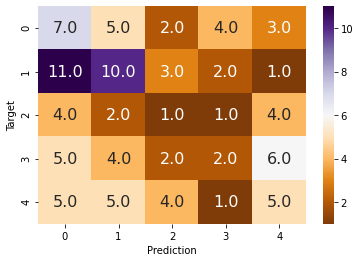

In [13]:
# Plot confusion matrix
from custom_packages import Diagnostic_Plots

confusion_matrix(y_test['Target'],y_test['Prediction'])

#### Appendix

##### Things to improve upon

1. Make the confusion matrix show Jabrils stuff
2. Are these the correct metrics for multi-category?
3. Should this stuff be in a pipeline?
4. Make it possible to iterate through the entire y_test dataset OR perform batch inferencing with the model
5. Make the code easier to read
6. Make num_classes flexible instead of hard-coded
7. Make a toggle for binary prediction


##### Longer Term

1. requirements.txt
2. Github repo
3. Move to AML